In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchviz
import torchinfo

from torch.utils.data import TensorDataset, DataLoader

In [4]:
# use after load data from hbase the df should be a dataframe containing hbase data, if traning data is 12 months and never will be trained again you should not choose lines like in line 8

df = pd.read_csv("merged_output.csv")

df['timestamp'] = pd.to_datetime(df['transition_date']) + pd.to_timedelta(df['transition_hour'], unit='h')

b=df.groupby(["timestamp","line","station_poi_desc_cd"]).sum()["number_of_passenger"].reset_index()

#unnecessary b_new = b[ ~(b.timestamp == "2020-03-01 00:00:00")	]


In [17]:
df.head()

,transition_date,transition_hour,line,number_of_passenger,station_poi_desc_cd,timestamp
0,2023-01-01,0,USKUDAR-CEKMEKOY,1,ALTUNIZADE 1,2023-01-01
1,2023-01-01,0,USKUDAR-CEKMEKOY,296,USKUDAR 1,2023-01-01
2,2023-01-01,0,KADIKOY-KARTAL,14,GOZTEPE,2023-01-01
3,2023-01-01,0,KADIKOY-KARTAL,5,GOZTEPE,2023-01-01
4,2023-01-01,0,USKUDAR-CEKMEKOY,1,CAKMAK,2023-01-01


In [16]:
b.head()

,timestamp,line,station_poi_desc_cd,number_of_passenger,day_of_week,month,hour
0,2023-01-01,ADALAR-BOSTANCI,BURGAZADA,19,6,1,0
1,2023-01-01,ADALAR-BOSTANCI,HEYBELIADA,52,6,1,0
2,2023-01-01,ADALAR-KABATAS,BURGAZADA,11,6,1,0
3,2023-01-01,ADALAR-KABATAS,BUYUKADA,67,6,1,0
4,2023-01-01,ADALAR-KABATAS,HEYBELIADA,14,6,1,0


In [59]:
pivoted_data2 = b.pivot_table(
    index='timestamp',
    columns=['line', 'station_poi_desc_cd'],  # Combine line and station for unique keys
    values='number_of_passenger'
).fillna(0)

In [64]:
pivoted_data2.head()

line                  ADALAR                                                 \
station_poi_desc_cd BOSTANCI BURGAZADA BUYUKADA HEYBELIADA KARTAL KINALIADA   
timestamp                                                                     
2023-01-01 00:00:00      0.0       0.0      0.0        0.0    0.0       0.0   
2023-01-01 01:00:00      0.0       0.0      0.0        0.0    0.0       0.0   
2023-01-01 02:00:00      0.0       0.0      0.0        0.0    0.0       0.0   
2023-01-01 03:00:00      0.0       0.0      0.0        0.0    0.0       0.0   
2023-01-01 04:00:00      0.0       0.0      0.0        0.0    0.0       0.0   

line                ADALAR-BOSTANCI                                ...  \
station_poi_desc_cd       BURGAZADA BUYUKADA HEYBELIADA KINALIADA  ...   
timestamp                                                          ...   
2023-01-01 00:00:00            19.0      0.0       52.0       0.0  ...   
2023-01-01 01:00:00            27.0      0.0        0.0      10.0  ...   
2023-01-01 02:00:00             3.0      0.0       17.0       5.0  ...   
2023-01-01 03:00:00             0.0      0.0        0.0       0.0  ...   
2023-01-01 04:00:00             0.0      0.0        0.0       0.0  ...   

line                YENIKAPI - HAVALIMANI                                 \
station_poi_desc_cd              OTOGAR 1 SAGMALCILAR TERAZIDERE UCYUZLU   
timestamp                                                                  
2023-01-01 00:00:00                  55.0        77.0       84.0    60.0   
2023-01-01 01:00:00                  44.0        58.0       19.0    29.0   
2023-01-01 02:00:00                  19.0        26.0       21.0    13.0   
2023-01-01 03:00:00                  15.0        22.0       11.0     5.0   
2023-01-01 04:00:00                  20.0        11.0        9.0     8.0   

line                                                        YENIKAPI-ADALAR  \
station_poi_desc_cd ULUBATLI YENIBOSNA YENIKAPI ZEYTINBURNU    YENI KABATAS   
timestamp                                                                     
2023-01-01 00:00:00     72.0      11.0   1803.0       122.0             0.0   
2023-01-01 01:00:00     25.0       5.0   2481.0       104.0             0.0   
2023-01-01 02:00:00     36.0       1.0   1707.0       103.0             0.0   
2023-01-01 03:00:00     12.0       1.0   1139.0       208.0             0.0   
2023-01-01 04:00:00     15.0       3.0    541.0        46.0             0.0   

line                YENIKOY-BEYKOZ  
station_poi_desc_cd        YENIKOY  
timestamp                           
2023-01-01 00:00:00            0.0  
2023-01-01 01:00:00            0.0  
2023-01-01 02:00:00            0.0  
2023-01-01 03:00:00            0.0  
2023-01-01 04:00:00            0.0  

[5 rows x 480 columns]

In [65]:
styled_df = pivoted_data2.head().style.set_table_styles(
    [
        {"selector": "thead", "props": [("background-color", "#1f77b4"), ("color", "white"), ("font-weight", "bold")]},
        {"selector": "tbody tr:nth-child(even)", "props": [("background-color", "#f2f2f2")]},
    ]
).hide(axis='index')  # Hide the index

# Save as HTML
styled_df.to_html("styled_table.html")

In [5]:
# data to model input converter 


# Step 1: Convert timestamp to datetime and extract day of the week and month
data=b
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['day_of_week'] = data['timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
data['month'] = data['timestamp'].dt.month
data['hour'] = data['timestamp'].dt.hour

# Step 2: Pivot the data to organize passenger numbers by station over time
pivoted_data = data.pivot_table(
    index='timestamp',
    columns=['line', 'station_poi_desc_cd'],  # Combine line and station for unique keys
    values='number_of_passenger'
).fillna(0)
degerler = np.array(pivoted_data.values)

standard_scaler = StandardScaler()
min_max = MinMaxScaler(feature_range=(0, 1))
#degerler = standard_scaler.fit_transform(degerler)
degerler = min_max.fit_transform(degerler)
pivoted_data = pd.DataFrame(degerler, columns=pivoted_data.columns, index=pivoted_data.index)

# Flatten the multi-index columns
pivoted_data.columns = ['_'.join(col) for col in pivoted_data.columns]

# Step 3: Add metadata for each timestamp (day_of_week and month)
metadata = data.drop_duplicates(subset=['timestamp'])[['timestamp', 'day_of_week', 'month', "hour"]].set_index('timestamp')

# Merge pivoted data with metadata
merged_data = pivoted_data.merge(metadata, left_index=True, right_index=True)

merged_data.to_csv("merged_output_ready.csv")
# Step 4: Create input-output pairs for time-series prediction
# We will use a rolling window approach for the input (past N hours) and target (next hour)
def create_time_series_data(df, target_col, sequence_length):
    """
    Creates time-series data for LSTM model input and target.
    
    :param df: DataFrame with features and target
    :param target_col: Target column for prediction
    :param sequence_length: Length of the past sequence to use as input
    :return: X (input data), y (target data)
    """
    
    X, y = [], []
    for i in range(sequence_length, len(df) - 1):
        X.append(df.iloc[i-sequence_length:i].values)
        y.append(df.iloc[i + 1][target_col])
    return np.array(X), np.array(y)

# Define parameters
sequence_length = 24  # Use past 24 hours as input

# Prepare input (X) and target (y) for all stations
station_columns = pivoted_data.columns.tolist()
X, y = create_time_series_data(merged_data[station_columns + ['day_of_week', 'month',"hour"]], station_columns, sequence_length)

# Step 5: Split the data into train, validation, and test sets


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the datasets
#X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

In [14]:

for i, durak in enumerate(pivoted_data.columns):
    print(i, " : ", durak)

0  :  ADALAR_BOSTANCI
1  :  ADALAR_BURGAZADA
2  :  ADALAR_BUYUKADA
3  :  ADALAR_HEYBELIADA
4  :  ADALAR_KARTAL
5  :  ADALAR_KINALIADA
6  :  ADALAR-BOSTANCI_BURGAZADA
7  :  ADALAR-BOSTANCI_BUYUKADA
8  :  ADALAR-BOSTANCI_HEYBELIADA
9  :  ADALAR-BOSTANCI_KINALIADA
10  :  ADALAR-KABATAS_BURGAZADA
11  :  ADALAR-KABATAS_BUYUKADA
12  :  ADALAR-KABATAS_HEYBELIADA
13  :  ADALAR-KABATAS_KINALIADA
14  :  ASIYAN-USKUDAR_USKUDAR
15  :  AVCILAR - BAKIRKOY-KADIKOY_KADIKOY SH
16  :  AVCILAR - BAKIRKOY-KADIKOY_KADIKOY YENI
17  :  AVCILAR - BAKIRKOY-KADIKOY_TUHIM AVCILAR
18  :  AVCILAR - BAKIRKOY-KADIKOY_TUHIM BAKIRKY
19  :  AVCILAR - BAKIRKOY-KADIKOY_YENIKAPI
20  :  AVCILAR - BOSTANCI_TUHIM AVCILAR
21  :  BAHARIYE-OLIMPIYAT_BAHARIYE
22  :  BAHARIYE-OLIMPIYAT_M9 IKITELLI
23  :  BAHARIYE-OLIMPIYAT_MASKO
24  :  BAHARIYE-OLIMPIYAT_OLIMPIYAT BATI
25  :  BAHARIYE-OLIMPIYAT_OLIMPIYAT DOGU
26  :  BAHARIYE-OLIMPIYAT_ZIYA GOKALP MAH.
27  :  BARBAROS-E.KADIKOY_BARBAROS
28  :  BARBAROS-E.KADIKOY_BESIKTAS
29  :  BE

In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(merged_data.shape)

(7842, 24, 483)
(7842, 480)
(872, 24, 483)
(872, 480)
(8739, 483)


In [7]:

X_train = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
X_test = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test = torch.tensor(np.array(y_test), dtype=torch.float32)

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position.float() * div_term)
        pe[:, 1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TimeSeriesTransformer(nn.Module):
    def __init__(self, feature_size=128, num_heads=8, num_layers=3, dropout=0.1, input_size=None):
        super(TimeSeriesTransformer, self).__init__()
        self.input_size = input_size
        self.feature_size = feature_size

        self.input_layer = nn.Linear(input_size, feature_size)
        self.positional_encoding = PositionalEncoding(d_model=feature_size, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(feature_size, input_size - 3)

    def forward(self, src):
        src = self.input_layer(src)
        src = src.permute(1, 0, 2)
        src = self.positional_encoding(src)
        output = self.transformer_encoder(src)
        output = output[-1, :, :]
        output = self.output_layer(output)
        return output

In [9]:
feature_size = 128
num_heads = 8
num_layers = 3
dropout = 0.1
lr = 1e-4
batch_size = 32
epochs = 50
total_stations = X_train.shape[2]
total_stations

483

In [16]:
model = TimeSeriesTransformer(
    feature_size=feature_size,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout,
    input_size=total_stations
)

c:\Users\yalci\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [17]:
# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TimeSeriesTransformer(
  (input_layer): Linear(in_features=483, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=480, bias=True)
)

In [18]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# DataLoaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [38]:
train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            output = model(X_val)
            loss = criterion(output, y_val)
            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    print(f'Epoch {epoch}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

Epoch 1, Training Loss: 0.0009, Validation Loss: 0.0008
Epoch 2, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 3, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 4, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 5, Training Loss: 0.0008, Validation Loss: 0.0009
Epoch 6, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 7, Training Loss: 0.0009, Validation Loss: 0.0008
Epoch 8, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 9, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 10, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 11, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 12, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 13, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 14, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 15, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 16, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 17, Training Loss: 0.0008, Validation Loss: 0.0008
Epoch 18, Training Loss: 0.0009, Validat

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1000x500 with 0 Axes>

In [40]:
torch.save(model.state_dict(), 'transformer_model_big.pth')

In [19]:
model.load_state_dict(torch.load('transformer_model_50_epoch_w_minmax.pth'))

<All keys matched successfully>

In [20]:
model.eval()
predictionss = []
actualss = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        output = model(X_batch)
        predictionss.append(output.cpu())
        actualss.append(y_batch.cpu())

predictionss = torch.cat(predictionss).numpy()
actualss = torch.cat(actualss).numpy()

# Inverse transform the scaling
predictionss_inv = min_max.inverse_transform(predictionss)
actualss_inv = min_max.inverse_transform(actualss)

In [23]:
predictionss_inv.shape

(872, 480)

In [27]:
total_error = 0
for i in range(len(predictionss_inv)):
    for j in range(len(predictionss_inv[i])):
        total_error += abs(actualss_inv[i][j] - predictionss_inv[i][j])

average_error = total_error / (len(predictionss_inv) * len(predictionss_inv[0]))
print("Average Error:", average_error)
accuracy = total_error / np.sum(actualss_inv)
print("Accuracy:", accuracy)

Average Error: 33.37716179903701
Accuracy: 0.13025777949445314


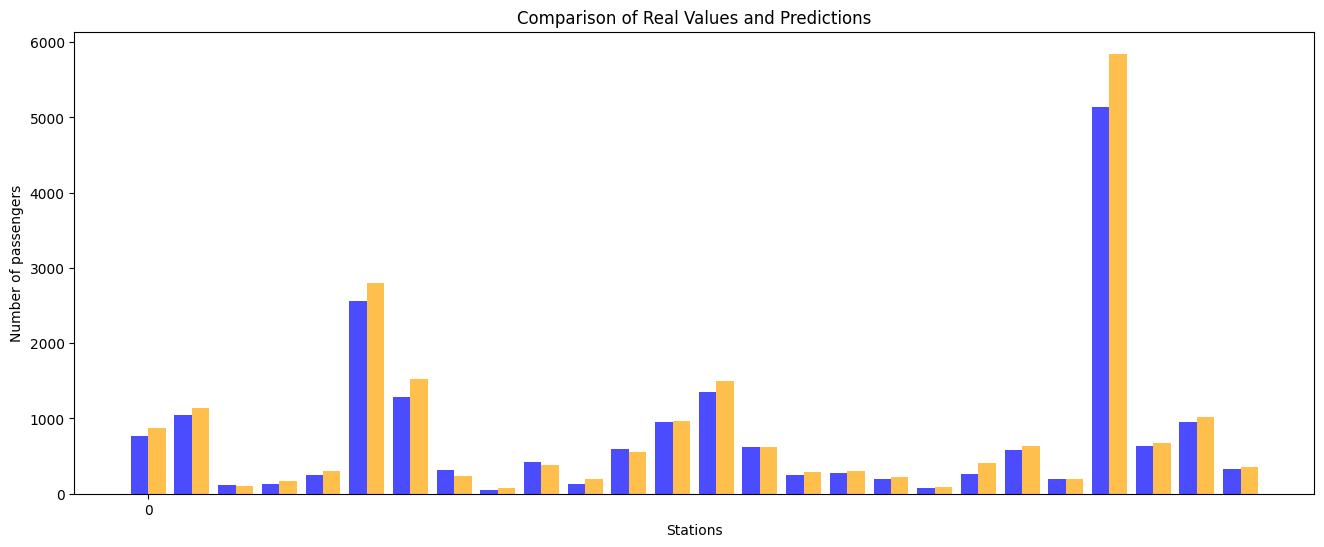

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
real_values = actualss_inv[100][424:450]  # Replace with your real values
predicted_values = predictionss_inv[100][424:450]  # Replace with your predictions
x = np.arange(26)  # Indices for the 480 values

# Plot settings
width = 0.4  # Narrow width for better distinction

plt.figure(figsize=(16, 6))  # Adjust figure size for better readability

# Plot real values and predictions side-by-side
plt.bar(x - width / 2, real_values, width, label='Real Values', color='blue', alpha=0.7)
plt.bar(x + width / 2, predicted_values, width, label='Predictions', color='orange', alpha=0.7)

# Add labels and title
plt.xlabel('Stations')
plt.ylabel('Number of passengers')
plt.title('Comparison of Real Values and Predictions')

# Optional: Show every nth tick on the x-axis to avoid overcrowding
plt.xticks(np.arange(0, 26, 50))  # Adjust ticks for large data

# Display the plot
plt.show()


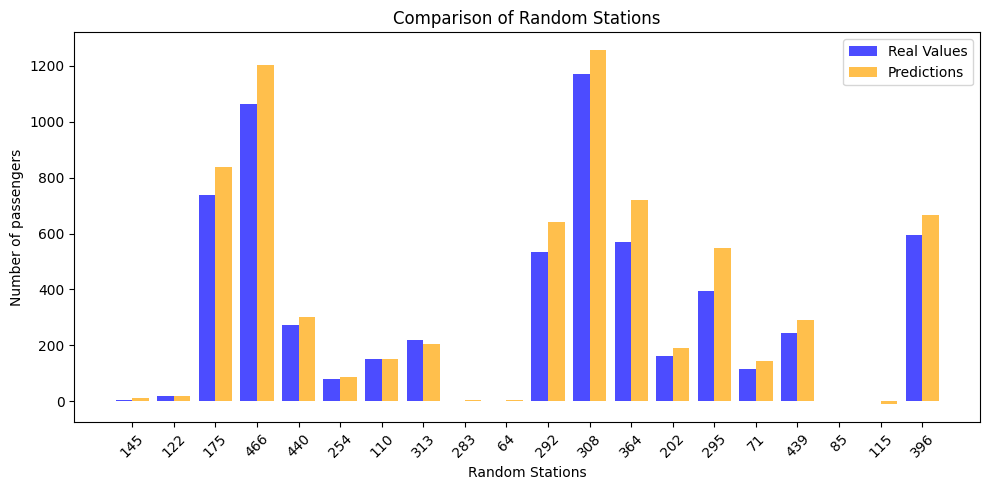

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
real_values = actualss_inv[100]  # Replace with your real values
predicted_values = predictionss_inv[100]  # Replace with your predictions

# Randomly select indexes
np.random.seed(44)  # For reproducibility
num_samples = 20  # Number of random samples to plot
random_indexes = np.random.choice(len(real_values), num_samples, replace=False)

# Extract corresponding values
sample_real_values = real_values[random_indexes]
sample_predicted_values = predicted_values[random_indexes]

# Plot settings
x = np.arange(num_samples)  # Indices for the bar positions
width = 0.4  # Bar width

plt.figure(figsize=(10, 5))  # Adjust figure size

# Plot real values and predictions
plt.bar(x - width / 2, sample_real_values, width, label='Real Values', color='blue', alpha=0.7)
plt.bar(x + width / 2, sample_predicted_values, width, label='Predictions', color='orange', alpha=0.7)

# Add labels and title
plt.xlabel('Random Stations')
plt.ylabel('Number of passengers')
plt.title(f'Comparison of Random Stations')
plt.xticks(x, random_indexes, rotation=45)  # Label bars with their original indexes
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()
